Imports

In [1]:
import sys

import networkx as nx

sys.path.append("/home/sanketh/DANI/GraphMatching/")

import torch.multiprocessing as mp
mp.set_start_method("spawn")

In [2]:
import pathlib
import os
import numpy as np
import torch
from torch import optim
import itertools
from common.parallel_computation import tqdm_joblib
import random
from tqdm import tqdm
from joblib import Parallel, delayed
from os import cpu_count
import pickle
from livelossplot import PlotLosses
import time
from common.logger import TimeLogging
from subgraph_matching_via_nn.data.data_loaders import load_graph
from powerful_gnns.models.graphcnn import GraphCNN
from powerful_gnns.util import separate_data
from powerful_gnns.classifier_training import train, test
from common.EmbeddingCalculationsService import pairwise_l2_distance, show_distance_matrix, \
    calculate_energy_based_hidden_rep
from subgraph_matching_via_nn.training.PairSampleInfo import Pair_Sample_Info
from subgraph_matching_via_nn.data.annotated_graph import AnnotatedGraph
from subgraph_matching_via_nn.training.trainer.S2VGraphEmbeddingSimilarityMetricTrainer import \
    S2VGraphEmbeddingSimilarityMetricTrainer
from common.graph_data_experiments_utils import *

In [3]:
processes_device_ids = ["cuda"] #[0, 2, 3, 4, 5, 6, 7]

In [4]:
goal_subcircuit_name = 'alu'
DATA_PATH = 'C:/Users/kogan/OneDrive/Desktop/Research/AMIT/GraphMatching/subgraph_matching_via_nn/data/subcircuits/'
DATA_PATH = '../subgraph_matching_via_nn/data/subcircuits/'

desktop = pathlib.Path(DATA_PATH)
subgraphs = []
labels = []
for circuit_dir in desktop.iterdir():
    if circuit_dir.is_dir():
        for subcircuit_file in circuit_dir.iterdir():
            if subcircuit_file.is_file():
                file_name = subcircuit_file.name
                if file_name == 'full_graph.p':
                    file_rel_path = f"{os.sep}{file_name}"
                    loader_params = {
                     'data_path' : str(circuit_dir),
                     'g_full_path': file_rel_path,
                     'g_sub_path': file_rel_path}

                    sub_graph = \
                        load_graph(type='subcircuit',
                                   loader_params=loader_params)

                    if goal_subcircuit_name in circuit_dir.name:
                        labels.append(1)
                    else:
                        # continue #TODO?
                        labels.append(0)
                    subgraphs.append(sub_graph)

labels = np.array(labels, dtype='float32')
N = len(subgraphs)
N_training = int(2 / 3 * N)

In [5]:
subgraphs = []
labels = []

subgraphs_for_classification = []

circuit_base_dir = 'C:\\Users\\kogan\\OneDrive\\Desktop\\Research\\AMIT\\GraphMatching\\subgraph_matching_via_nn\\data\\subcircuits\\'
# circuit_base_dir = '/home/sanketh/DANI/GraphMatching/subgraph_matching_via_nn/data/subcircuits/'
CIRCUIT_DUPLICATES_AMOUNT = 5
REFERENCE_GRAPH_ORIGINAL_LABEL = 1
REFERENCE_GRAPH_ORIGINAL_INDEX = 0

for circuit_file_name in ['adder_4', 'alu_4', 'alu_8', 'alu_16', 'alu_32', 'mul_4_4', 'mul_4_8', 'mul_8_8', 'mul_16_16', 'mul_16_32']:
    file_rel_path = 'full_graph.p'
    circuit_dir = f"{circuit_base_dir}{circuit_file_name}{os.sep}"
    loader_params = {
     'data_path' : str(circuit_dir),
     'g_full_path': file_rel_path,
     'g_sub_path': file_rel_path}

    sub_graph = \
        load_graph(type='subcircuit',
                   loader_params=loader_params)
    subgraphs.append(sub_graph)
    for i in range(CIRCUIT_DUPLICATES_AMOUNT):
        subgraphs_for_classification.append(sub_graph)
        labels.append(0)
for i in range(CIRCUIT_DUPLICATES_AMOUNT):
    labels[REFERENCE_GRAPH_ORIGINAL_INDEX * CIRCUIT_DUPLICATES_AMOUNT + i] = REFERENCE_GRAPH_ORIGINAL_LABEL

zipped_graphs_and_labels = list(zip(subgraphs_for_classification, labels))
random.shuffle(zipped_graphs_and_labels)
unzipped_graphs_and_labels = list(zip(*zipped_graphs_and_labels))
subgraphs_for_classification = unzipped_graphs_and_labels[0]
labels = unzipped_graphs_and_labels[1]

N = len(subgraphs_for_classification)
N_training = int(2 / 3 * N)

Transform graphs into S2VGraph-s

In [6]:
device = 'cpu' if torch.cuda.is_available() else 'cpu'

In [7]:
graphs, num_classes = transform_into_s2vgraphs(subgraphs_for_classification, labels, device)

# classes: 2
# maximum node tag: 48
# data: 50


Setup model and training

In [8]:
#set up seeds and gpu device
torch.manual_seed(0)
np.random.seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)

##k-fold cross validation. Conduct an experiment on the fold specified by args.fold_idx.
# train_graphs, test_graphs = separate_data(graphs, seed=0, fold_idx=0, n_splits=1)
# train_graphs = graphs[:4]
# test_graphs = graphs[4:]
train_graphs = graphs[:N_training]
test_graphs = graphs[N_training:]

model = GraphCNN(num_layers=5, num_mlp_layers = 2, input_dim=train_graphs[0].node_features.shape[1], hidden_dim=64, output_dim=num_classes, final_dropout=0.5, learn_eps=False, graph_pooling_type="sum", neighbor_pooling_type="sum", device=device)

optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

Train and Test

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "c:\users\kogan\appdata\local\programs\python\python38\lib\inspect.py", line 2987, in _bind
    arg_val = kwargs.pop(param_name)
KeyError: 'required'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\users\kogan\.virtualenvs\subcircuit_recognition-mmb-fima\lib\site-packages\IPython\core\interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-d49f7aed7e85>", line 23, in <module>
    liveloss.send()
  File "c:\users\kogan\.virtualenvs\subcircuit_recognition-mmb-fima\lib\site-packages\livelossplot\plot_losses.py", line 41, in send
    output.send(self.logger)
  File "c:\users\kogan\.virtualenvs\subcircuit_recognition-mmb-fima\lib\site-packages\livelossplot\outputs\matplotlib_plot.py", line 70, in send
    self._after_plots(fig)
  File "c:\users\kogan\.virtualenvs\subcircuit_recognition-mmb-fima\lib\site-packages\liv

TypeError: can only concatenate str (not "list") to str

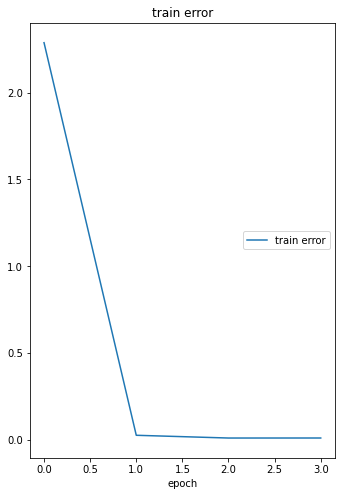

In [9]:
liveloss = PlotLosses(mode='notebook')

filename = ""
epochs = 20
k_update_plot = 1

for epoch in range(1, epochs + 1):
    scheduler.step()

    avg_loss = train(iters_per_epoch=50, batch_size=len(train_graphs), model=model, device=device, train_graphs=train_graphs, optimizer=optimizer, epoch=epoch)
    acc_train, acc_test = test(model, device, train_graphs, test_graphs, epoch)

    if not filename == "":
        with open(filename, 'w') as f:
            f.write("%f %f %f" % (avg_loss, acc_train, acc_test))
            f.write("\n")
    print("")

    print(model.eps)

    if epoch % k_update_plot == 0:
        liveloss.update({'train error': avg_loss.item()})
        liveloss.send()

In [10]:
acc_train

1.0

In [11]:
acc_test

1.0

Show predictions

In [12]:
model.eval()
pred = model(train_graphs).max(1, keepdim=True)[1]
print(pred)

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1]])


In [13]:
pred = model(test_graphs).max(1, keepdim=True)[1]
print(pred)

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [0],
        [0],
        [0],
        [1],
        [0],
        [0],
        [0],
        [0]])


show all distances matrix (margin)

In [9]:
# keep only one instance of each graph
graphs, num_classes = transform_into_s2vgraphs(subgraphs, labels, device)

all_embeddings = model.get_embedding(graphs)

# classes: 2
# maximum node tag: 48
# data: 10


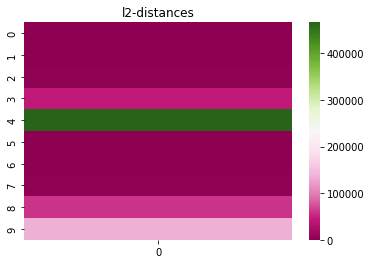

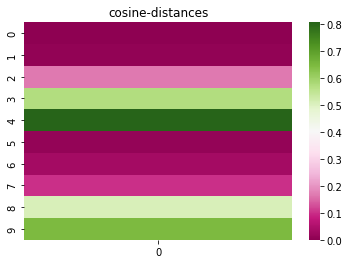

In [10]:
l2_dists = pairwise_l2_distance(all_embeddings)[REFERENCE_GRAPH_ORIGINAL_INDEX].reshape(-1, 1)

rounding_constant = 10 ** 3
cos_dists = (torch.round(calculate_energy_based_hidden_rep(all_embeddings, threshold=-1) * rounding_constant) / rounding_constant)[REFERENCE_GRAPH_ORIGINAL_INDEX].reshape(-1, 1)

show_distance_matrix(l2_dists, "l2-distances")
show_distance_matrix(cos_dists, "cosine-distances")

what is the smallest margin?

In [11]:
print(get_min_non_diagonal_entry(l2_dists, device, REFERENCE_GRAPH_ORIGINAL_INDEX))
print(get_min_non_diagonal_entry(cos_dists, device, REFERENCE_GRAPH_ORIGINAL_INDEX))

43.02388000488281
0.007000000216066837


Contrastive loss training

Assemble graph pairs data

In [12]:
train_samples_list = []
reference_subgraph = subgraphs[REFERENCE_GRAPH_ORIGINAL_INDEX]
negative_examples_subgraphs = subgraphs[:REFERENCE_GRAPH_ORIGINAL_INDEX] + subgraphs[REFERENCE_GRAPH_ORIGINAL_INDEX+1:]

for subgraph in subgraphs:
    if subgraph == reference_subgraph:
        is_negative_example = False
    else:
        is_negative_example = True

    G1_annotated = AnnotatedGraph(subgraph.G)
    G2_annotated = AnnotatedGraph(reference_subgraph.G)
    train_samples_list.append(Pair_Sample_Info(
        subgraph=G1_annotated,
        masked_graph=G2_annotated,
        is_negative_sample=torch.tensor(is_negative_example)))

val_samples_list = train_samples_list

Define GNN model

In [13]:
# input dim matches the node mask (w) shape
input_dim = S2VGraphEmbeddingSimilarityMetricTrainer.get_model_expected_input_dim(train_samples_list[0])
model_factory_func = lambda device: GraphCNN(num_layers=5, num_mlp_layers = 2, input_dim=input_dim, hidden_dim=64, output_dim=num_classes, final_dropout=0.5, learn_eps=False, graph_pooling_type="sum", neighbor_pooling_type="sum", device=device)

Define graph metric to train, and the trainer

In [14]:
solver_params = {
    "device": device,
    "lr": 1e-3, "weight_decay": 1e-3,
    "max_epochs": 50,
    "cycle_patience": 5, "step_size_up": 10, "step_size_down": 10,
    "loss_convergence_threshold": None,
    "train_loss_convergence_threshold": 1e-3,
    "successive_convergence_min_iterations_amount": 5,
    "margin_loss_margin_value": 5,
    "max_grad_norm": 0.1,
    "k_update_plot": 1,
    "train_monitoring_epochs_pace": 5,
    "batch_size": len(subgraphs),
    "num_workers": 0,
    "is_use_model_compliation": False, #Only supported for Pytorch > 2.0
    "model_checkpoint_epochs_pace": 10,
}

problem_params = {"input_dim": input_dim}

trainer, graph_metric_nn, model = init_embedding_net_and_trainer(model_factory_func, solver_params, problem_params)

Train

In [ ]:
# show_distances_heatmap(generate_s2v_graphs([graph.g for graph in graphs], device), model, device)

In [ ]:
trainer.train(processes_device_ids=['cpu'], use_existing_data_loaders=False, train_samples_list=train_samples_list, val_samples_list=val_samples_list)

In [ ]:
show_distances_heatmap(generate_s2v_graphs([graph.g for graph in graphs], device), model, device)

Add ged=1 examples as positive examples

In [ ]:
# generate subgraphs for which ged(subgraph, reference_subgraph)==1
perturbed_graphs = list(generate_perturbed_graphs(reference_subgraph.G_sub))
for perturbed_graph in perturbed_graphs:
    is_negative_example = False

    G1_annotated = AnnotatedGraph(perturbed_graph)
    G2_annotated = AnnotatedGraph(reference_subgraph.G)
    train_samples_list.append(Pair_Sample_Info(
        subgraph=G1_annotated,
        masked_graph=G2_annotated,
        is_negative_sample=torch.tensor(is_negative_example)))

In [ ]:
len(train_samples_list)

In [ ]:
val_samples_list = train_samples_list
model_factory_func = lambda device: GraphCNN(num_layers=5, num_mlp_layers = 2, input_dim=input_dim, hidden_dim=64, output_dim=num_classes, final_dropout=0.5, learn_eps=False, graph_pooling_type="sum", neighbor_pooling_type="sum", device=device)
solver_params["batch_size"] = len(train_samples_list)

trainer, graph_metric_nn, model = init_embedding_net_and_trainer(model_factory_func, solver_params, problem_params)

trainer.train(processes_device_ids=['cpu'], use_existing_data_loaders=False, train_samples_list=train_samples_list, val_samples_list=val_samples_list)

In [ ]:
all_s2v_graphs = generate_s2v_graphs([subgraph.G for subgraph in subgraphs] + perturbed_graphs, device)
# show_distances_heatmap(all_s2v_graphs, model, device)

In [ ]:
show_distances_heatmap(all_s2v_graphs[:len(subgraphs)], model, device)

In [ ]:
reference_s2v_graph = all_s2v_graphs[REFERENCE_GRAPH_ORIGINAL_INDEX]
reference_graph_with_positive_examples = [reference_s2v_graph] + all_s2v_graphs[len(subgraphs):]
reference_graph_with_negative_examples = [all_s2v_graphs[i] for i in range(len(all_s2v_graphs[:len(subgraphs)]))]

In [ ]:
show_distances_heatmap(reference_graph_with_positive_examples, model, device, show_min_off_diagonal=False)

In [ ]:
show_distances_heatmap(reference_graph_with_negative_examples, model, device, show_min_off_diagonal=True)

In [ ]:
_ = graph_metric_nn.eval()

In [ ]:
positive_distances = []
for positive_example_second_graph in reference_graph_with_positive_examples:
    distance = graph_metric_nn.forward([(reference_s2v_graph, positive_example_second_graph)]).item()
    positive_distances.append(distance)
    if distance > solver_params['margin_loss_margin_value']:
        print(f"positive loss term not zero, as distance for this positive example pair is {distance}")

negative_distances = []
for negative_example_second_graph in reference_graph_with_negative_examples:
    if negative_example_second_graph == reference_s2v_graph:
        continue #ignore the same graph with itself
    distance = graph_metric_nn.forward([(reference_s2v_graph, negative_example_second_graph)]).item()
    negative_distances.append(distance)
    if distance < solver_params['margin_loss_margin_value']:
        print(f"negative loss term not zero, as distance for this negative example pair is {distance}")

In [ ]:
max(positive_distances)

In [ ]:
min(negative_distances)

k-subgraphs experiment

In [ ]:
K = 11
full_graph = reference_subgraph.G

subgraphs_iterator = itertools.combinations(full_graph, K)
k_subgraphs = [full_graph.subgraph(s) for s in subgraphs_iterator]
k_subgraph_annotated_graphs = [AnnotatedGraph(g, label=i) for i, g in enumerate(k_subgraphs)]

train_samples_list = []
isomorphic_pairs = []
train_sample_indices_tuple_list = []

In [ ]:
for subgraph_counter1, SG_annotated_1 in enumerate(k_subgraph_annotated_graphs):
    for subgraph_counter2 in range(subgraph_counter1+1, len(k_subgraph_annotated_graphs)):
        SG_annotated_2 = k_subgraph_annotated_graphs[subgraph_counter2]
        train_samples_list.append(compare_graphs_and_generate_pair_example(SG_annotated_1, SG_annotated_2, isomorphic_pairs))
        train_sample_indices_tuple_list.append((subgraph_counter1, subgraph_counter2))
        # if train_samples_list[-1].is_negative_sample == False:
        #     print(f"{subgraph_counter1} vs {subgraph_counter2}")

In [ ]:
used_train_samples_list = train_samples_list[:10_000]

In [ ]:
model_factory_func = lambda device: GraphCNN(num_layers=5, num_mlp_layers = 2, input_dim=input_dim, hidden_dim=128, output_dim=num_classes, final_dropout=0.5, learn_eps=False, graph_pooling_type="sum", neighbor_pooling_type="sum", device=device)
solver_params["batch_size"] = 512
solver_params["k_update_plot"] = 1
solver_params["lr"] = 1e-1
solver_params["max_epochs"] = 50
trainer, graph_metric_nn, model = init_embedding_net_and_trainer(model_factory_func, solver_params, problem_params, graph_metric_nn_checkpoint_path=None)

trainer.train(processes_device_ids=[0], use_existing_data_loaders=False, train_samples_list=used_train_samples_list, val_samples_list=[])

In [ ]:
trainer, graph_metric_nn, model = init_embedding_net_and_trainer(model_factory_func, solver_params, problem_params, graph_metric_nn_checkpoint_path="./mp/1704585490.4369323/best_model_state_dict.pt")
_ = graph_metric_nn.eval()

In [ ]:
train_positive_distances, train_negative_distances = get_examples_distances(trainer, graph_metric_nn, used_train_samples_list)
plot_histogram(train_positive_distances, "positive pair distances", min_range=0, max_range=20)
plot_histogram(train_negative_distances, "negative pair distances", min_range=0, max_range=20)
calc_margin_loss(torch.tensor(train_positive_distances+train_negative_distances), torch.cat((torch.ones(len(train_positive_distances)), torch.zeros(len(train_negative_distances)))), margin = solver_params['margin_loss_margin_value'])

In [ ]:
# ged_pairs_dump_base_path = f".{os.sep}ged_pairs

# loaded_ged_examples = []
# for i, doc_path in enumerate(pathlib.Path(ged_pairs_dump_base_path).rglob("*.p*")):
#     k_subgraph_ged_pairs_list = pickle.load(open(doc_path, 'rb'))
#     loaded_ged_examples += k_subgraph_ged_pairs_list
#     print(i)

# if not os.path.exists(ged_pairs_dump_base_path):
#     os.makedirs(ged_pairs_dump_base_path)
#
# # k_subgraph_to_perturbed_graphs_map = {}
# def generate_ged_paris(subgraph_counter1):
#     train_samples_list = []
#     SG1 = k_subgraph_annotated_graphs[subgraph_counter1]
#     ged1_perturbed_graphs = list(generate_perturbed_graphs(SG1.g))
#     for ged1_perturbed_graph in ged1_perturbed_graphs:
#         # positive example
#         train_samples_list.append(generate_pair_example(SG1, AnnotatedGraph(ged1_perturbed_graph), is_negative_example = False))
#
#         ged2_perturbed_graphs = list(generate_perturbed_graphs(ged1_perturbed_graph))
#         for ged2_perturbed_graph in ged2_perturbed_graphs:
#             # could be positive or negative example
#             train_samples_list.append(compare_graphs_and_generate_pair_example(k_subgraph_annotated_graphs[subgraph_counter1], AnnotatedGraph(ged2_perturbed_graph)))
#
#     path = os.path.join(ged_pairs_dump_base_path, f"subgraph_{subgraph_counter1}.p")
#     with open(path, 'wb') as f:
#         pickle.dump(train_samples_list, f)
#     return train_samples_list
#
# total_tasks = len(k_subgraphs)
# with tqdm_joblib(tqdm(desc="My calculation", total=total_tasks)) as progress_bar:
#     #Parallel(n_jobs=16)(delayed(long_task)() for i in range(10))
#
#     ged_examples = Parallel(n_jobs=int(cpu_count()), prefer='processes')(
#         delayed(generate_ged_paris)(subgraph_counter1=subgraph_counter1)
#         for subgraph_counter1 in range(total_tasks)
#     )
#
# # generate subgraphs for which GED==1
# for subgraph_counter1, SG1 in enumerate(k_subgraphs):
#     print(subgraph_counter1)
#     ged1_perturbed_graphs = list(generate_perturbed_graphs(SG1))
#     for ged1_perturbed_graph in ged1_perturbed_graphs:
#         # positive example
#         train_samples_list.append(generate_pair_example(SG1, ged1_perturbed_graph, is_negative_example = False))
#         #
#         # ged2_perturbed_graphs = list(generate_perturbed_graphs(ged1_perturbed_graph))
#         # for ged2_perturbed_graph in ged2_perturbed_graphs:
#         #     # could be positive or negative example
#         #     train_samples_list.append(compare_graphs_and_generate_pair_example(k_subgraph_annotated_graphs[subgraph_counter1], AnnotatedGraph(ged2_perturbed_graph)))
#     # k_subgraph_to_perturbed_graphs_map[SG1] = perturbed_graphs

#
#
# # generate all pairs examples
# for SG1, SG1_perturbed_graphs in k_subgraph_to_perturbed_graphs_map.items():
#     for SG2, SG2_perturbed_graphs in k_subgraph_to_perturbed_graphs_map.items():
#
#         if SG1 == SG2:
#             continue # trivial pairs, or pairs already considered
#
#         for SG2_perturbed_graph in SG2_perturbed_graphs:
#             train_samples_list.append(compare_graphs_and_generate_pair_example(SG1, SG2_perturbed_graph))
#
#         for SG1_perturbed_graph in SG1_perturbed_graphs:
#             train_samples_list.append(compare_graphs_and_generate_pair_example(SG1_perturbed_graph, SG2))

In [ ]:
random_k_subgraphs = generate_k_subgraph(reference_subgraph, k=9)

In [ ]:
len(random_k_subgraphs)

In [ ]:
POSITIVE_EXAMPLES_GED_DIST_pairs_n = 20 #2000
POSITIVE_EXAMPLES_GED_DIST = 1
POSITIVE_EXAMPLES_k_subgraphs = random_k_subgraphs

NEGATIVE_EXAMPLES_GED_DIST_pairs_n = 20
NEGATIVE_EXAMPLES_GED_DIST = 4 #4
NEGATIVE_EXAMPLES_k_subgraphs = random_k_subgraphs#[:20]

ged_examples1, ged_examples2 = generate_positive_and_negative_ged_pairs(POSITIVE_EXAMPLES_k_subgraphs, POSITIVE_EXAMPLES_GED_DIST, POSITIVE_EXAMPLES_GED_DIST_pairs_n, NEGATIVE_EXAMPLES_k_subgraphs, NEGATIVE_EXAMPLES_GED_DIST, NEGATIVE_EXAMPLES_GED_DIST_pairs_n)

ged_examples = ged_examples1 + ged_examples2
random.shuffle(ged_examples)

train_ratio = 0.7
train_ged_examples_amount = int(len(ged_examples) * train_ratio)
train_ged_examples = ged_examples[:train_ged_examples_amount]
eval_ged_examples = ged_examples[train_ged_examples_amount:]

In [ ]:
len(train_ged_examples)

In [ ]:
len(ged_examples2)

In [ ]:
len(ged_examples1)

In [ ]:
for k_subgraph in k_subgraphs:
    if k_subgraphs[0].nodes == k_subgraph.nodes:
        print("yes")

In [ ]:
len(k_subgraphs)

In [ ]:
len(train_ged_examples)

check 1-WL distance

In [ ]:
# optimized single call for WL distance calculation
### NOTE: Wl dist is not stable (depends which batch of graph you applied it with) ###
# wl_dist_matrix = get_graph_wl_distances(k_subgraphs, node_label=False)

# negative_pairs_wl_distances = []
# positive_pairs_wl_distances = []
#
# positive_pairs_index_to_dist_map = {}
# negative_pairs_index_to_dist_map = {}
#
# for i, train_sample in enumerate(train_samples_list):
#     is_negative_sample = train_sample.is_negative_sample
#     graph1 = train_sample.subgraph
#     graph2 = train_sample.masked_graph
#
#     # s2v_graphs = generate_s2v_graphs([graph1.g, graph2.g], device, print_stats=False)
#
#     # distance = graph_metric_nn.forward([(s2v_graphs[0], s2v_graphs[1])]).item()
#
#     # wl_dist = get_graph_wl_distances([graph1.g, graph2.g], node_label=False)[0][1]
#
#     graph1_index, graph2_index = train_sample_indices_tuple_list[i]
#     wl_dist = wl_dist_matrix[graph1_index][graph2_index]
#     wl_dist = round(wl_dist, 6)
#
#     if is_negative_sample:
#         negative_pairs_wl_distances.append(wl_dist)
#         negative_pairs_index_to_dist_map[i] = wl_dist
#     else:
#         positive_pairs_wl_distances.append(wl_dist)
#         positive_pairs_index_to_dist_map[i] = wl_dist

In [ ]:
# _, _ = show_wl_dist_histograms(ged_1_examples, ged_2_examples, max_examples_amount = 1_000)

In [ ]:
# margin = 0.001
# calc_margin_loss(torch.tensor(positive_pairs_wl_distances+negative_pairs_wl_distances), torch.cat((torch.ones(len(positive_pairs_wl_distances)), torch.zeros(len(negative_pairs_wl_distances)))), margin)

Fit GNN on k subgraph GED pairs

In [ ]:
# disable debugging overhead operations
torch.autograd.set_detect_anomaly(mode=False)

In [ ]:
solver_params['margin_loss_margin_value'] = 0.5 #0.25 #0.01

In [ ]:
# used_train_samples_amount = 50_000
used_train_samples_list = train_ged_examples#[:used_train_samples_amount] #Needed due to performance issues

In [ ]:
len(used_train_samples_list)

In [ ]:
last_checkpoint_model_path = None

# val_samples_list = used_train_samples_list
model_factory_func = lambda device: GraphCNN(num_layers=5, num_mlp_layers = 2, input_dim=input_dim, hidden_dim=128, output_dim=num_classes, final_dropout=0.5, learn_eps=False, graph_pooling_type="sum", neighbor_pooling_type="sum", device=device)
solver_params["batch_size"] = 512 * 8 #32 #2048 #1024 #512
solver_params["k_update_plot"] = 1
solver_params["lr"] = 1e-1
solver_params["max_epochs"] = 200 #480--
trainer, graph_metric_nn, model = init_embedding_net_and_trainer(model_factory_func, solver_params, problem_params, graph_metric_nn_checkpoint_path=last_checkpoint_model_path)

# trainer.set_existing_data_loader_paths(
#     ['./dataloaders/1702148493.0283618.p',
#  './dataloaders/1702148497.9922142.p',
#  './dataloaders/1702148502.9499629.p',
#  './dataloaders/1702148511.1819935.p'],
# []
# )

In [ ]:
trainer.train(processes_device_ids=processes_device_ids, use_existing_data_loaders=False, train_samples_list=used_train_samples_list, val_samples_list=[])

In [ ]:
# GED2 -> "./mp/1703271648.8009052/best_model_state_dict.pt", not seperable well
# GED4 - > ""./mp/1703279923.1549501/best_model_state_dict.pt", seperable well (not perfect but close)

In [ ]:
trainer, graph_metric_nn, model = init_embedding_net_and_trainer(model_factory_func, solver_params, problem_params, graph_metric_nn_checkpoint_path="./mp/1703411975.73806/best_model_state_dict.pt")
_ = graph_metric_nn.eval()

In [ ]:
train_positive_distances, train_negative_distances = get_examples_distances(trainer, graph_metric_nn, used_train_samples_list)

In [ ]:
len(train_negative_distances) / len(train_positive_distances)

In [ ]:
plot_histogram(train_positive_distances, "train positive examples", min_range=0, max_range=1)

In [ ]:
plot_histogram(train_negative_distances, "train negative examples", min_range=0, max_range=10)

In [ ]:
calc_margin_loss(torch.tensor(train_positive_distances+train_negative_distances), torch.cat((torch.ones(len(train_positive_distances)), torch.zeros(len(train_negative_distances)))), margin = solver_params['margin_loss_margin_value'])

Train again without rebuilding data loaders, and without the val_loader

In [ ]:
# model_factory_func = lambda device: GraphCNN(num_layers=5, num_mlp_layers = 2, input_dim=input_dim, hidden_dim=64, output_dim=num_classes, final_dropout=0.5, learn_eps=False, graph_pooling_type="sum", neighbor_pooling_type="sum", device=device)
# new_trainer, graph_metric_nn, model = init_embedding_net_and_trainer(model_factory_func, solver_params, problem_params)

# new_trainer.previous_train_loader_paths = trainer.previous_train_loader_paths
# new_trainer.previous_val_loader_paths = [None for device_id in processes_device_ids] #trainer.previous_val_loader_paths
# new_trainer.train(processes_device_ids=processes_device_ids, use_existing_data_loaders=True)

In [ ]:
_, _ = calc_performance_metrics(graph_metric_nn, used_train_samples_list, train_positive_distances, train_negative_distances, solver_params, device)

Generalization error

In [ ]:
eval_positive_distances, eval_negative_distances = get_examples_distances(trainer, graph_metric_nn, eval_ged_examples)

In [ ]:
plot_histogram(eval_positive_distances, "eval positive examples", max_range=10)

In [ ]:
plot_histogram(eval_negative_distances, "eval negative examples", max_range=10)

In [ ]:
calc_margin_loss(torch.tensor(eval_positive_distances+eval_negative_distances), torch.cat((torch.ones(len(eval_positive_distances)), torch.zeros(len(eval_negative_distances)))), margin = solver_params['margin_loss_margin_value'])

In [ ]:
_, _ = calc_performance_metrics(graph_metric_nn, eval_ged_examples, eval_positive_distances, eval_negative_distances, solver_params, device)

Execution time profiling

In [ ]:
# from cProfile import Profile
# from pstats import SortKey, Stats

# with Profile() as profile:
#     new_trainer.train(processes_device_ids=processes_device_ids, use_existing_data_loaders=True)
#     (
#     Stats(profile)
#         .strip_dirs()
#         .sort_stats(SortKey.CUMULATIVE)
#         .print_stats()
#     )

## save used_train_samples_list

In [ ]:
ref_graphs_with_negative_eaxmples = set([annotated_graph.label for annotated_graph in NEGATIVE_EXAMPLES_k_subgraphs])
ref_graphs_with_positive_eaxmples = set([annotated_graph.label for annotated_graph in POSITIVE_EXAMPLES_k_subgraphs])
reg_graphs_with_negative_and_positive_examples = ref_graphs_with_negative_eaxmples.intersection(ref_graphs_with_positive_eaxmples)

reference_graph_to_pairs_for_training_list_map = {}

for pair in used_train_samples_list:
    ref_graph = pair.subgraph
    ref_graph_label = pair.subgraph.label

    if ref_graph_label not in reg_graphs_with_negative_and_positive_examples:
        continue
    
    paired_graph = pair.masked_graph

    lst = []
    if ref_graph_label in reference_graph_to_pairs_for_training_list_map:
        lst = reference_graph_to_pairs_for_training_list_map[ref_graph_label]
    lst.append(pair)
    reference_graph_to_pairs_for_training_list_map[ref_graph_label] = lst

In [ ]:
dump_base_path = f".{os.sep}ged_train_subset"
if not os.path.exists(dump_base_path):
    os.makedirs(dump_base_path)

dump_path = os.path.join(dump_base_path, f"{str(time.time())}.p")
with open(dump_path, 'wb') as f:
    pickle.dump(reference_graph_to_pairs_for_training_list_map, f)

In [ ]:
p_ctr = 0
n_ctr = 0
for k, v in reference_graph_to_pairs_for_training_list_map.items():
    for example in v:
        if example.is_negative_sample:
            n_ctr += 1
        else:
            p_ctr += 1

In [ ]:
p_ctr

In [ ]:
n_ctr

Capacity test

In [ ]:
hidden_dim = 16
num_layers = 5
num_mlp_layers = 2
model_factory_func = lambda device: GraphCNN(num_layers=num_layers, num_mlp_layers = num_mlp_layers, input_dim=input_dim, hidden_dim=hidden_dim, output_dim=1, final_dropout=0.5, learn_eps=False, graph_pooling_type="sum", neighbor_pooling_type="sum", device=device)
solver_params["batch_size"] = 512 * 8
solver_params["k_update_plot"] = 10
solver_params["lr"] = 1e-1
solver_params["max_epochs"] = 200
current_trainer, graph_metric_nn, model = init_embedding_net_and_trainer(model_factory_func, solver_params, problem_params, graph_metric_nn_checkpoint_path="./mp/1705969912.0095499/best_model_state_dict.pt")

In [ ]:
trainer = None
hid_dim_to_val_loss_map = {}
for hid_dim in [16, 32, 64, 128, 256, 512, 1024, 2048]:
    trainer, graph_metric_nn, best_val_loss = train_model_with_hyperparams(used_train_samples_list, solver_params, problem_params, processes_device_ids, hidden_dim=hid_dim, trainer=trainer)
    hid_dim_to_val_loss_map[hid_dim] = best_val_loss
    print(f"{hid_dim}: {best_val_loss}")

In [ ]:
print(hid_dim_to_val_loss_map)
plot_map(hid_dim_to_val_loss_map, "hidden_dim", "val loss", "model performance vs model capacity")

Expressivity test

In [ ]:
positive_GED_k_to_negative_GED_k_to_val_loss_map = {}
pairs_n = 800
positive_examples_k_subgraphs = random_k_subgraphs[:20]
ged_positive_examples_cache_map = {}
ged_negative_examples_cache_map = {}

for positive_GED_k in [2, 3, 4, 5, 6, 7]:
    negative_GED_k_to_val_loss_map = {}
    positive_GED_k_to_negative_GED_k_to_val_loss_map[positive_GED_k] = negative_GED_k_to_val_loss_map

    # prepare positive pairs dataset
    with tqdm_joblib(tqdm(desc="My calculation", total=len(positive_examples_k_subgraphs))) as progress_bar:
        ged_positive_examples = Parallel(n_jobs=int(cpu_count()), prefer='processes')(
            delayed(generate_random_ged_paris)(annotated_subgraph=annotated_subgraph, ged_dist=positive_GED_k, pairs_n=pairs_n, is_negative_example=False, force_exactly_pairs_n=False)
            for annotated_subgraph in positive_examples_k_subgraphs
        )
    ged_positive_examples = [elem for lst in ged_positive_examples for elem in lst]
    ged_positive_examples_cache_map[positive_GED_k] = ged_positive_examples
    print(f"#pos examples = {len(ged_positive_examples)}")

    for negative_GED_k in range(positive_GED_k + 1, 9):
        print(f"expressivity test for positive_GED_k={positive_GED_k} & negative_GED_k={negative_GED_k}")

        if negative_GED_k in ged_negative_examples_cache_map:
            ged_negative_examples = ged_negative_examples_cache_map[negative_GED_k]
        else:

            # prepare negative pairs dataset
            with tqdm_joblib(tqdm(desc="My calculation", total=len(NEGATIVE_EXAMPLES_k_subgraphs))) as progress_bar:
                ged_negative_examples = Parallel(n_jobs=int(cpu_count()), prefer='processes')(
                    delayed(generate_random_ged_paris)(annotated_subgraph=annotated_subgraph, ged_dist=negative_GED_k, pairs_n=pairs_n, is_negative_example=True, force_exactly_pairs_n=False)
                    for annotated_subgraph in NEGATIVE_EXAMPLES_k_subgraphs
                )

            ged_negative_examples = [elem for lst in ged_negative_examples for elem in lst]
            ged_negative_examples_cache_map[negative_GED_k] = ged_negative_examples
        print(f"#neg examples = {len(ged_negative_examples)}")

        # combine examples to one dataset
        ged_examples = ged_positive_examples + ged_negative_examples
        random.shuffle(ged_examples)

        train_ratio = 0.7
        train_ged_examples_amount = int(len(ged_examples) * train_ratio)
        train_ged_examples = ged_examples[:train_ged_examples_amount]
        eval_ged_examples = ged_examples[train_ged_examples_amount:]

        print(f"#train set examples = {len(train_ged_examples)}")

        # train
        trainer, graph_metric_nn, best_val_loss = train_model_with_hyperparams(train_ged_examples, solver_params, problem_params, processes_device_ids, hidden_dim=64, trainer=None)
        negative_GED_k_to_val_loss_map[negative_GED_k] = best_val_loss
        print(f"negative K={negative_GED_k}: val_loss={best_val_loss}")

        # more performance metrics
        _ = graph_metric_nn.eval()

        train_positive_distances, train_negative_distances = get_examples_distances(trainer, graph_metric_nn, train_ged_examples)
        _, _ = calc_performance_metrics(graph_metric_nn, train_ged_examples, train_positive_distances, train_negative_distances, solver_params, device)

        eval_positive_distances, eval_negative_distances = get_examples_distances(trainer, graph_metric_nn, eval_ged_examples)
        _, _ = calc_performance_metrics(graph_metric_nn, eval_ged_examples, eval_positive_distances, eval_negative_distances, solver_params, device)
        calc_margin_loss(torch.tensor(eval_positive_distances+eval_negative_distances), torch.cat((torch.ones(len(eval_positive_distances)), torch.zeros(len(eval_negative_distances)))), margin = solver_params['margin_loss_margin_value'])

        plot_histogram(train_positive_distances, "train positive examples", min_range=0, max_range=2)
        plot_histogram(train_negative_distances, "train negative examples", min_range=0, max_range=2)
        plot_histogram(eval_positive_distances, "eval positive examples", min_range=0, max_range=2)
        plot_histogram(eval_negative_distances, "eval negative examples", min_range=0, max_range=2)

In [ ]:
GED_experiments_map = {}
for positive_GED_k, negative_GED_k_to_val_loss_map in positive_GED_k_to_negative_GED_k_to_val_loss_map.items():
    for negative_GED_k, val_loss in negative_GED_k_to_val_loss_map.items():
        GED_experiments_map[f"{positive_GED_k}_{negative_GED_k}"] = val_loss

chart_bar_plot(GED_experiments_map, "positive-GED-K_negative-GED-K", "validation loss", "model expressivity analysis")

test of 2D features space to illustrate the GED - apply MDS to separate the pairs (show the separation of the two areas) show we get a smooth wrap function using a higher dimensional embedding

In [ ]:
# choose reference graph s.
reference_graph_for_GED_visualization = random_k_subgraphs[0]

# generate 50 s+GED-1 graphs for positive examples (remember label)
# generate 50 s+GED-4 graphs for negative examples (remember label)
negative_ged_pairs, positive_ged_pairs = create_ged_visulaization_graphs(reference_graph_for_GED_visualization, label_class_examples_amount=500, positive_GED=3, negative_GED=6)

In [ ]:
# load trained pairs, and visualize some reference graphs and their pairs
trained_pairs_path = f".{os.sep}ged_train_subset{os.sep}1705968201.9176743.p"
trained_pairs_map = pickle.load(open(trained_pairs_path, 'rb'))

In [ ]:
ctr = 0
for ref_graph_label, ref_graph_pairs in trained_pairs_map.items():
    if len(ref_graph_pairs) > 35:
        neg_pairs_ctr = 0
        for pair in ref_graph_pairs:
            if pair.is_negative_sample:
                neg_pairs_ctr += 1
        print(f"reference graph label: {ref_graph_label}, negative pairs amount = {neg_pairs_ctr}")
        ctr += 1

print(ctr)

In [ ]:
def visualize_embeddings_for_trained_model(ref_graph, positive_pairs, negative_pairs, solver_params, problem_params, input_dim, num_classes):
    for hidden_dim in [16, 32, 64, 128, 256, 512, 1024, 2048]:
        print(hidden_dim)
        model_dump_path = get_model_dump_path(hidden_dim)

        model_factory_func = lambda device: GraphCNN(num_layers=5, num_mlp_layers = 2, input_dim=input_dim, hidden_dim=hidden_dim, output_dim=num_classes, final_dropout=0.5, learn_eps=False, graph_pooling_type="sum", neighbor_pooling_type="sum", device=device)

        _, graph_metric_nn, _ = init_embedding_net_and_trainer(model_factory_func, solver_params, problem_params, graph_metric_nn_checkpoint_path=model_dump_path)

        # calc embeddings of all pairs, apply MDS and plot
        visualize_embeddings(graph_metric_nn, ref_graph, positive_pairs, negative_pairs, device=device)

In [ ]:
selected_train_reference_graph_pairs = trained_pairs_map[1799]
selected_train_reference_graph = selected_train_reference_graph_pairs[0].subgraph
selected_train_reference_graph_positive_pairs = [pair for pair in selected_train_reference_graph_pairs if pair.is_negative_sample == False]
selected_train_reference_graph_negative_pairs = [pair for pair in selected_train_reference_graph_pairs if pair.is_negative_sample == True]

visualize_embeddings_for_trained_model(selected_train_reference_graph, selected_train_reference_graph_positive_pairs, selected_train_reference_graph_negative_pairs, solver_params, problem_params, input_dim=1, num_classes=1, device=device)

In [ ]:
visualize_embeddings_for_trained_model(reference_graph_for_GED_visualization, positive_ged_pairs, negative_ged_pairs, solver_params, problem_params, input_dim=1, num_classes=1, device=device)

In [ ]:
gt_labels = [0] + [0 for pair in positive_ged_pairs] + [1 for pair in negative_ged_pairs]
hid_dim_to_clustering_score_maps_map = {}

for hidden_dim in [16, 32, 64, 128, 256, 512, 1024, 2048]:
    model_dump_path = get_model_dump_path(hidden_dim)
    model_factory_func = lambda device: GraphCNN(num_layers=5, num_mlp_layers = 2, input_dim=1, hidden_dim=hidden_dim, output_dim=1, final_dropout=0.5, learn_eps=False, graph_pooling_type="sum", neighbor_pooling_type="sum", device=device)

    _, graph_metric_nn, _ = init_embedding_net_and_trainer(model_factory_func, model_dump_path)

    # calc embeddings of all pairs
    all_embeddings = get_embeddings(graph_metric_nn, reference_graph_for_GED_visualization, positive_ged_pairs, negative_ged_pairs)\
    .detach().cpu().numpy()

    # cluster and measure clustering quality
    hid_dim_to_clustering_score_maps_map[hidden_dim] = measure_clustering(all_embeddings, gt_labels)

In [ ]:
hid_dim_to_clustering_score_maps_map

In [ ]:
show_score_plot(hid_dim_to_clustering_score_maps_map, 'sil', 'silhouette')

In [ ]:
show_score_plot(hid_dim_to_clustering_score_maps_map, 'dav', 'davies-bouldin')

In [ ]:
show_score_plot(hid_dim_to_clustering_score_maps_map, 'nmi', 'nmi')

In [ ]:
# metric vs GED 3D plot
# 	for the X and Y, use radius-s of GED, e.g. for radius =1, all GED-1 examples (against a fixed reference graph)

# interactive mode may cause issues, see: https://stackoverflow.com/questions/51922480/javascript-error-ipython-is-not-defined-in-jupyterlab

%matplotlib notebook

In [ ]:
#TODO:
# 	what about the sampled graphs in the space, are they random? or they are sampled real subgraphs from the full graph?
# 		allow both configurations:
# 			all GED
# 			just existing sampled subgraphs GED (we can color them among all GED actually)

In [ ]:
visualize_reference_graph_model_loss_space(solver_params, problem_params, 1024, random_k_subgraphs[10], GED_dists = [1, 4], max_samples_per_radius = 50)

In [ ]:
multiple_ged_radiuses_graphs_map = visualize_reference_graph_model_loss_space(solver_params, problem_params, 1024, random_k_subgraphs[15], GED_dists = [1, 4, 9], max_samples_per_radius = 500)

In [ ]:
multiple_ged_radiuses_graphs_map = visualize_reference_graph_model_loss_space(solver_params, problem_params, 1024, random_k_subgraphs[15], GED_dists = [1, 4, 9], max_samples_per_radius = 500)

In [ ]:
visualize_reference_graph_model_loss_space(solver_params, problem_params, 1024, reference_graph_for_GED_visualization, GED_dists = [3, 6], max_samples_per_radius = 50)

In [ ]:
train_ged_dist_to_pairs_map = {1: selected_train_reference_graph_positive_pairs, 4: selected_train_reference_graph_negative_pairs}
visualize_reference_graph_model_loss_space(solver_params, problem_params, 1024, selected_train_reference_graph, GED_dists = train_ged_dist_to_pairs_map, max_samples_per_radius = 50)

In [ ]:
train_positive_distances, train_negative_distances = calc_margin_loss_for_pairs(trainer, graph_metric_nn, solver_params, selected_train_reference_graph_positive_pairs + selected_train_reference_graph_negative_pairs)

In [ ]:
max(train_positive_distances)

In [ ]:
min(train_negative_distances)

In [ ]:
trainer, graph_metric_nn = create_metric_and_trainer(hidden_dim=1024, solver_params=solver_params, problem_params=problem_params)
_ = graph_metric_nn.eval()
epoch_val_loss = 0
val_samples_list = positive_ged_pairs + negative_ged_pairs
stub_train_samples_list = val_samples_list[:1]
train_loaders, val_loaders = trainer.get_data_loaders(stub_train_samples_list, val_samples_list, 0, ['cpu'])
val_loader = val_loaders[0]

for val_batch in val_loader:
    val_loss = trainer.calculate_loss_for_batch(val_batch, is_train=False)
    epoch_val_loss += val_loss.item()

In [ ]:
epoch_val_loss

In [ ]:
# all_train_reference_graph_pairs = [pair for _, train_reference_graph_pairs in trained_pairs_map.items() for pair in train_reference_graph_pairs]
train_positive_distances, train_negative_distances = get_examples_distances(trainer, graph_metric_nn, ged_examples1 + ged_examples2)

calc_margin_loss(torch.tensor(train_positive_distances+train_negative_distances), torch.cat((torch.ones(len(train_positive_distances)), torch.zeros(len(train_negative_distances)))), margin = solver_params['margin_loss_margin_value'])

In [ ]:
plot_histogram(train_positive_distances, "positive pair distances", min_range=0, max_range=1)
plot_histogram(train_negative_distances, "negative pair distances", min_range=0, max_range=7)

In [ ]:
plot_histogram_for_ged_pairs(trainer, graph_metric_nn, 1, multiple_ged_radiuses_graphs_map[1])

In [ ]:
plot_histogram_for_ged_pairs(trainer, graph_metric_nn, 4, multiple_ged_radiuses_graphs_map[4], max_range=0.2)

In [ ]:
plot_histogram_for_ged_pairs(trainer, graph_metric_nn, 4, multiple_ged_radiuses_graphs_map[4], max_range=1)

In [ ]:
plot_histogram_for_ged_pairs(trainer, graph_metric_nn, 4, multiple_ged_radiuses_graphs_map[4])

In [ ]:
plot_histogram_for_ged_pairs(trainer, graph_metric_nn, 9, multiple_ged_radiuses_graphs_map[9])

In [ ]:
plot_histogram_for_ged_pairs(trainer, graph_metric_nn, 9, multiple_ged_radiuses_graphs_map[9], max_range=3)

In [ ]:
# plt.close('all')

# Brute force training

In [15]:
brute_force_k_subgraph_annotated_graphs, brute_force_k_subgraphs, G_perturbed, G_sub = generate_pairs_data_set(circuit_base_dir=circuit_base_dir, circuit_file_name = 'comp1_2')

enter generate_pairs_data_set
full graph has 16 nodes, subgraph has 8 nodes, removing 4 non subgraph nodes from full graph
starting generating subgraphs
start generate_k_subgraphs
enter generate_k_subgraphs
total time for finished all_connected_subgraphs (total of 420 graphs):0s
total time for finished generating subgraphs:2s
total time for end generate_k_subgraphs:2s
enter generate_pairs_data_set_based_on_graphs


Pairs dataset construction: 100%|██████████| 8/8 [01:54<00:00, 14.29s/it]

total time for finished generate_pairs_data_set_based_on_graphs:114s
total time for finished generate_pairs_data_set:117s


In [16]:
def load_dump_file_pairs_dataset(path, n_partitions=8): #88
    samples_list = []
    for chunk_index in range(0, n_partitions):
        with open(f'{path}{os.sep}{chunk_index}.p', 'rb') as file:
            tmp_samples_list = pickle.load(file)
        print(len(tmp_samples_list))
        samples_list += tmp_samples_list
    return samples_list

brute_force_train_samples_list = load_dump_file_pairs_dataset("brute_force_pairs", n_partitions=8) #n_partitions=88

20829
18020
15211
12402
9593
6784
3975
1176


In [17]:
len(brute_force_k_subgraph_annotated_graphs)

420

In [18]:
used_train_samples_list = brute_force_train_samples_list

In [19]:
len(used_train_samples_list)

87990

In [20]:
positive_examples = [pair for pair in used_train_samples_list if pair.is_negative_sample==False]
positive_examples_graphs_labels = set([pair.subgraph.label for pair in positive_examples] + [pair.masked_graph.label for pair in positive_examples])
positive_examples_graphs = [g for g in brute_force_k_subgraph_annotated_graphs if g.label in positive_examples_graphs_labels ]

In [21]:
# why 372 choose 2 does not produce 2916? (if g1 is isomorphic to g2, and g2 to g3, then g1 should be to g3)
# -> since each g1 has its own set of isomorphic graphs
total_isomorphic_pairs_amount = 0
for i, candidate_isomorphic_graph in enumerate(positive_examples_graphs):
    candidate_g = candidate_isomorphic_graph.g.copy()
    remove_isolated_nodes_from_graph(candidate_g)
    for j in range(i+1, len(positive_examples_graphs)):
        candidate_g2 = positive_examples_graphs[j].g.copy()
        remove_isolated_nodes_from_graph(candidate_g2)
        if nx.is_isomorphic(candidate_g2, candidate_g):
            total_isomorphic_pairs_amount += 1

In [22]:
total_isomorphic_pairs_amount

2916

In [23]:
# histogram of isomorphic pairs per k_subgraph

k_subgraph_label_to_total_isomorphic_pairs_amount_map = {}
k_subgraph_label_to_isomorphic_pairs_labels_map = {}

for target_label, k_subgraph in enumerate(brute_force_k_subgraph_annotated_graphs):
    if target_label in k_subgraph_label_to_total_isomorphic_pairs_amount_map:
        # already counted by the isomorphic graph label
        continue

    isomorphic_pairs_amount = 0
    target_k_subgraph = k_subgraph.g.copy()
    remove_isolated_nodes_from_graph(target_k_subgraph)

    isomorphic_graph_labels = []

    for candidate_label, candidate_isomorphic_graph in enumerate(brute_force_k_subgraph_annotated_graphs):
        if target_label == candidate_label:
            continue

        candidate_g = candidate_isomorphic_graph.g.copy()
        remove_isolated_nodes_from_graph(candidate_g)
        if nx.is_isomorphic(target_k_subgraph, candidate_g):
            isomorphic_pairs_amount += 1
            isomorphic_graph_labels.append(candidate_label)

            # mark candidate in order to skip its future loop processing
            k_subgraph_label_to_total_isomorphic_pairs_amount_map[candidate_label] = None

    k_subgraph_label_to_total_isomorphic_pairs_amount_map[target_label] = isomorphic_pairs_amount
    k_subgraph_label_to_isomorphic_pairs_labels_map[target_label] = isomorphic_graph_labels

In [24]:
k_subgraph_label_to_total_isomorphic_pairs_amount_map_for_plot = {k:v for k, v in k_subgraph_label_to_total_isomorphic_pairs_amount_map.items() if v is not None}

In [25]:
k_subgraph_label_to_total_isomorphic_pairs_amount_map_for_plot

{0: 1,
 1: 20,
 7: 11,
 8: 5,
 9: 8,
 13: 7,
 16: 11,
 18: 17,
 29: 11,
 30: 5,
 32: 5,
 35: 23,
 36: 11,
 37: 14,
 47: 35,
 48: 19,
 49: 10,
 65: 10,
 96: 1,
 97: 0,
 120: 1,
 126: 8,
 128: 8,
 137: 11,
 138: 2,
 142: 5,
 144: 5,
 147: 23,
 148: 5,
 154: 5,
 155: 0,
 156: 2,
 158: 4,
 159: 19,
 164: 9,
 189: 0,
 218: 2,
 223: 8,
 224: 2,
 247: 3,
 248: 0,
 319: 5,
 332: 2,
 342: 5,
 348: 5,
 370: 0,
 398: 0,
 404: 9}

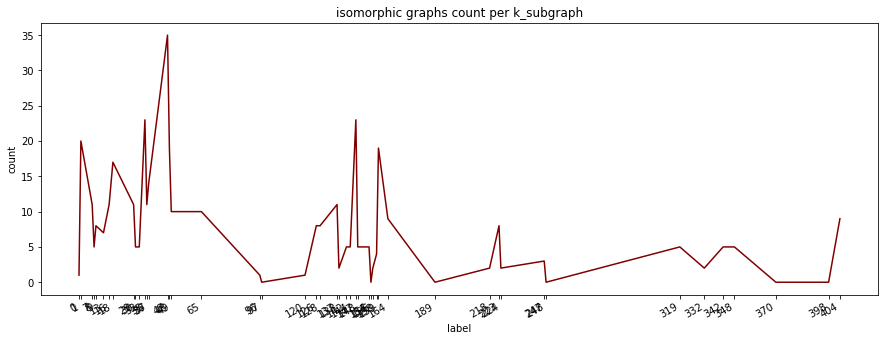

In [26]:
plot_map(k_subgraph_label_to_total_isomorphic_pairs_amount_map_for_plot, 'label', 'count', 'isomorphic graphs count per k_subgraph')
# 6 k_subgraphs with no isomophic examples

In [27]:
def get_map_keys_with_value_of(map, target_val):
    for key, val in map.items():
        if val == target_val:
            print(key)

In [28]:
get_map_keys_with_value_of(k_subgraph_label_to_total_isomorphic_pairs_amount_map, 0)

97
155
189
248
370
398


In [29]:
target_k_subgraph_label = 97
target_graph = positive_examples_graphs[target_k_subgraph_label].g.copy() #G_sub.copy()
remove_isolated_nodes_from_graph(target_graph)
target_graph.nodes

NodeView((0, 1, 2, 3, 4, 5, 6, 7))

In [30]:
hidden_dim = 16
num_layers = 5
num_mlp_layers = 2
model_factory_func = lambda device: GraphCNN(num_layers=num_layers, num_mlp_layers = num_mlp_layers, input_dim=input_dim, hidden_dim=hidden_dim, output_dim=1, final_dropout=0.5, learn_eps=False, graph_pooling_type="sum", neighbor_pooling_type="sum", device=device)
solver_params["batch_size"] = 512 * 8
solver_params["k_update_plot"] = 1
solver_params["lr"] = 1e-1
solver_params["max_epochs"] = 200

In [31]:
current_trainer, graph_metric_nn, model = init_embedding_net_and_trainer(model_factory_func, solver_params, problem_params, graph_metric_nn_checkpoint_path=None)

In [ ]:
current_trainer.train(processes_device_ids=processes_device_ids, use_existing_data_loaders=False, train_samples_list=used_train_samples_list, val_samples_list=[])

In [32]:
trainer, graph_metric_nn, model = init_embedding_net_and_trainer(model_factory_func, solver_params, problem_params, graph_metric_nn_checkpoint_path=".\\mp\\1707569240.828771\\best_model_state_dict.pt")

In [33]:
# +take one of the inference sampling algorithms we have (greedy)
# 	apply metric on all k-subgraphs, and show the min is achieved on the target graph
# 		if not, use also the harmonic mean distance for tie breaking

In [34]:
# extract pairs for target_graph.label masked_graph
target_graph_pairs = [pair for pair in brute_force_train_samples_list if target_k_subgraph_label in [pair.masked_graph.label, pair.subgraph.label]]

In [35]:
len(target_graph_pairs)

419

In [36]:
graph_metric_nn.eval()
train_positive_distances, train_negative_distances, self_pair = get_pairs_distances_for_target_graph(trainer, graph_metric_nn, target_k_subgraph_label = target_k_subgraph_label, all_pairs=brute_force_train_samples_list, all_graphs=brute_force_k_subgraph_annotated_graphs)

In [37]:
# plot_histogram_for_ged_pairs(trainer, graph_metric_nn, None, target_graph_pairs, max_range=None)

In [38]:
self_pair_distance = get_examples_distances(trainer, graph_metric_nn, [self_pair])[0][0]

In [39]:
self_pair_distance

0.0

In [40]:
train_positive_distances

[0.0]

In [41]:
sorted(train_negative_distances)

[10.703161239624023,
 10.703161239624023,
 10.703166007995605,
 10.703170776367188,
 10.703170776367188,
 10.703170776367188,
 10.703170776367188,
 10.703170776367188,
 10.703170776367188,
 16.148950576782227,
 17.471580505371094,
 17.471580505371094,
 17.471580505371094,
 17.471580505371094,
 17.471580505371094,
 17.47158432006836,
 30.01300048828125,
 30.01300048828125,
 30.01300048828125,
 30.01300048828125,
 30.01300048828125,
 30.01300048828125,
 30.01300048828125,
 30.01300048828125,
 30.01300048828125,
 30.01300048828125,
 30.01300048828125,
 30.260583877563477,
 30.260587692260742,
 30.260587692260742,
 30.260587692260742,
 30.260587692260742,
 30.260587692260742,
 30.260591506958008,
 30.260591506958008,
 30.26059341430664,
 30.26059341430664,
 30.26059341430664,
 30.26059341430664,
 40.23685073852539,
 46.62874984741211,
 46.628753662109375,
 46.628753662109375,
 46.628753662109375,
 46.628753662109375,
 46.628753662109375,
 46.628753662109375,
 46.628753662109375,
 46.628753

In [42]:
# show isomorphic graphs compared to the reference graph
for annotated_g in brute_force_k_subgraph_annotated_graphs:
    g = annotated_g.g.copy()
    remove_isolated_nodes_from_graph(g)
    if nx.is_isomorphic(G_sub, g):
        print(annotated_g.label)

0
217


In [43]:
train_positive_distances, train_negative_distances, self_pair = get_pairs_distances_for_target_graph(trainer, graph_metric_nn, target_k_subgraph_label = 0, all_pairs=brute_force_train_samples_list, all_graphs=brute_force_k_subgraph_annotated_graphs)

In [44]:
train_positive_distances

[9.686473845249566e-12, 0.0]

In [45]:
self_pair_distance = get_examples_distances(trainer, graph_metric_nn, [self_pair])[0][0]

In [46]:
self_pair_distance

0.0

In [47]:
sorted(train_negative_distances)

[10.032857894897461,
 10.032857894897461,
 10.032857894897461,
 10.032857894897461,
 10.032861709594727,
 10.03286361694336,
 10.03286361694336,
 10.032869338989258,
 59.15463638305664,
 82.713623046875,
 82.713623046875,
 82.713623046875,
 82.713623046875,
 82.713623046875,
 82.71363067626953,
 220.48788452148438,
 220.48793029785156,
 220.48793029785156,
 257.8414306640625,
 257.8414306640625,
 257.8414306640625,
 257.8414611816406,
 257.8414611816406,
 257.8414611816406,
 257.8414611816406,
 257.8414611816406,
 257.8414611816406,
 257.84149169921875,
 257.84149169921875,
 257.84149169921875,
 257.84149169921875,
 257.84149169921875,
 257.84149169921875,
 257.84149169921875,
 257.84149169921875,
 257.84149169921875,
 257.84149169921875,
 257.84149169921875,
 257.8415222167969,
 263.910888671875,
 263.910888671875,
 263.910888671875,
 263.910888671875,
 263.910888671875,
 263.9109191894531,
 263.9109191894531,
 263.9109191894531,
 263.9109191894531,
 263.91094970703125,
 263.910949707

In [48]:
# Select a target graph with several isomorphic matches, and check their similarities
get_map_keys_with_value_of(k_subgraph_label_to_total_isomorphic_pairs_amount_map, 10)

49
65


In [49]:
target_graph_with_multiple_isomorphic_graphs_label = 49
target_graph_with_multiple_isomorphic_graphs = brute_force_k_subgraph_annotated_graphs[target_graph_with_multiple_isomorphic_graphs_label]

chosen_graph_isomorphic_pairs = [pair for pair in brute_force_train_samples_list if (pair.is_negative_sample==False) and (target_graph_with_multiple_isomorphic_graphs_label in [pair.masked_graph.label, pair.subgraph.label])]

#each k subgraph should have its own original nodes
chosen_graph_isomorphic_graphs = [brute_force_k_subgraphs[p.masked_graph.label].copy() for p in chosen_graph_isomorphic_pairs]
for g in chosen_graph_isomorphic_graphs:
    remove_isolated_nodes_from_graph(g)

In [50]:
k_subgraph_label_to_total_isomorphic_pairs_amount_map[target_graph_with_multiple_isomorphic_graphs.label]

10

In [51]:
len(chosen_graph_isomorphic_pairs)

10

In [52]:
train_positive_distances, train_negative_distances, self_pair = get_pairs_distances_for_target_graph(trainer, graph_metric_nn, target_k_subgraph_label = target_graph_with_multiple_isomorphic_graphs_label, all_pairs=brute_force_train_samples_list, all_graphs=brute_force_k_subgraph_annotated_graphs)

In [53]:
train_positive_distances

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [54]:
assert len(train_positive_distances) == 1 + len(chosen_graph_isomorphic_graphs) # including self pair

In [55]:
# out sources metric

from subgraph_matching_via_nn.utils.utils import get_graph_adj_mat_as_tensor
from torch import nn
import torch
import numpy as np
from torch.autograd import Variable as V

REALLY_BIG_NUM = float("inf")

def build_param_graph(G, device):
    parameter_graph = []
    parameters = []
    for i in range(len(G)):
        edges = []
        parameter_graph.append(edges)
        for j in range(len(G)):
            if G[i][j] != 0:
                d = G[i][j]
                param = nn.Parameter(torch.ones(1, device=device))
                parameters.append(param)
                edges.append((j, param, d))
    return parameter_graph, parameters

def torch_dijsktra(gr, device):
    graph_dim = len(gr)
    graph_copy = torch.ones((graph_dim, graph_dim), device=device) * REALLY_BIG_NUM

    distances = np.empty(graph_dim, dtype=np.float32)
    for i, edges in enumerate(gr):
        distances.fill(REALLY_BIG_NUM)
        distances[i] = 0
        torch_dist = graph_copy[i]
        torch_dist[i] = V(torch.zeros(1, device=device))
        for _ in range(graph_dim):
            v = distances.argmin()
            v_dist = torch_dist[v]
            distances[v] = np.inf  # won't be selected by argmin , i.e. removed from the pool
            for neighbor, d, min_d in gr[v]:
                new_d = v_dist + d.clamp(min=0, max=1) * min_d
                existing_d = torch_dist[neighbor]
                if existing_d is None or (new_d < existing_d):
                    torch_dist[neighbor] = new_d
                    distances[neighbor] = new_d.detach().cpu().numpy()[0]

    return graph_copy

def get_out_sources_mean_distance(target_graph, full_graph_adj, source_graphs, graph_node_to_adj_node_map):
    parameter_graph, parameters = build_param_graph(full_graph_adj, device)

    dijkstra_distances = torch_dijsktra(parameter_graph, device)
    target_graph_nodes_as_sources_dijkstra_distances = torch.stack([dijkstra_distances[graph_node_to_adj_node_map[node]] for node in target_graph.nodes]).T
    shortest_paths_to_target_graph_nodes = torch.min(target_graph_nodes_as_sources_dijkstra_distances, dim=1).values

    # access adj_matrix via node -> adj_node map passed as a parameter
    subgraphs_mean_distances = [
        torch.max(torch.stack([shortest_paths_to_target_graph_nodes[graph_node_to_adj_node_map[node]] for node in subgraph.nodes]))
        for subgraph in source_graphs]

    return subgraphs_mean_distances
#
#
# from torch import optim
# device = 'cuda'
# parameter_graph, parameters = build_param_graph(sub_graph.A_sub
#                                                 , device)
#
# optimizer = optim.SGD(parameters,
#                       lr=0.01, momentum=0.5)
#
# for epoch in range(100):
#     dijkstra_distances = torch_dijsktra(parameter_graph, device)
#     loss = torch.stack([e for lst in dijkstra_distances for e in lst]).sum()
#
#     print(loss)
#     epoch_loss = loss.item()
#
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()

In [56]:
# adj matrix has size of 12, but the subgraphs have node numbers in the range [0,15], need to preserve node mapping!
brute_force_k_subgraphs[target_graph_with_multiple_isomorphic_graphs_label].nodes

NodeView((0, 2, 3, 4, 5, 12, 14, 15, 1, 6, 7, 13))

In [57]:
def generate_adj_matrix_with_nodes_mapping(graph: nx.Graph):
    nodelist = graph.nodes

    graph_node_to_adj_node_map = {node:i for i, node in enumerate(nodelist)}

    return torch.from_numpy((nx.adjacency_matrix(graph, nodelist=nodelist)).toarray()), graph_node_to_adj_node_map

In [58]:
full_graph_with_multiple_isomorphic_graphs_adj_mat, graph_node_to_adj_node_map = generate_adj_matrix_with_nodes_mapping(G_perturbed)

In [59]:
graph_node_to_adj_node_map

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 12: 8, 13: 9, 14: 10, 15: 11}

In [60]:
# make sure no isomorphic graphs, if there are make some manipulation
# show tie breaking using out source distance term

self_graph = brute_force_k_subgraphs[target_graph_with_multiple_isomorphic_graphs_label].copy()
remove_isolated_nodes_from_graph(self_graph)

out_source_distances = get_out_sources_mean_distance(target_graph=self_graph, full_graph_adj=full_graph_with_multiple_isomorphic_graphs_adj_mat, source_graphs=[self_graph] + chosen_graph_isomorphic_graphs, graph_node_to_adj_node_map=graph_node_to_adj_node_map)

In [61]:
out_source_distances

[tensor(0., grad_fn=<MaxBackward1>),
 tensor(1., grad_fn=<MaxBackward1>),
 tensor(1., grad_fn=<MaxBackward1>),
 tensor(1., grad_fn=<MaxBackward1>),
 tensor(1., grad_fn=<MaxBackward1>),
 tensor(1., grad_fn=<MaxBackward1>),
 tensor(1., grad_fn=<MaxBackward1>),
 tensor(1., grad_fn=<MaxBackward1>),
 tensor(1., grad_fn=<MaxBackward1>),
 tensor(1., grad_fn=<MaxBackward1>),
 tensor(1., grad_fn=<MaxBackward1>)]

In [62]:
sorted(train_negative_distances)

[13.536992073059082,
 13.536993980407715,
 13.536993980407715,
 13.536993980407715,
 13.536993980407715,
 13.536993980407715,
 16.349098205566406,
 16.349098205566406,
 16.349098205566406,
 16.349098205566406,
 16.349098205566406,
 16.349098205566406,
 16.349098205566406,
 16.349098205566406,
 16.349098205566406,
 16.349098205566406,
 16.349098205566406,
 16.349098205566406,
 16.349098205566406,
 16.349098205566406,
 16.349098205566406,
 16.349098205566406,
 16.349103927612305,
 16.349103927612305,
 16.349103927612305,
 16.349103927612305,
 16.349103927612305,
 16.349103927612305,
 16.349103927612305,
 16.349103927612305,
 17.089088439941406,
 17.089088439941406,
 17.08909034729004,
 17.08909034729004,
 17.08909034729004,
 17.08909034729004,
 17.08909034729004,
 17.08909034729004,
 17.089094161987305,
 17.089094161987305,
 17.089094161987305,
 17.089094161987305,
 18.254261016845703,
 18.93629264831543,
 18.93629264831543,
 18.936298370361328,
 18.936311721801758,
 18.936311721801758,


In [64]:
# train on sample of the dataset, not all pairs, eval on the other set

# Split all graphs first, and then generate the pairs datasets (keep isomorphic graphs together in the same dataset)
#   split graphs by using k_subgraph_label_to_isomorphic_pairs_labels_map

In [63]:
len(k_subgraph_label_to_isomorphic_pairs_labels_map)

48

In [64]:
from sklearn.model_selection import train_test_split

def generate_pairs_datasets_for_model_generalization(k_subgraph_label_to_isomorphic_pairs_labels_map, k_subgraph_annotated_graphs, train_size=0.7):
    graph_isomorphic_group_labels_train, graph_isomorphic_group_labels_test = train_test_split(list(k_subgraph_label_to_isomorphic_pairs_labels_map.keys()), shuffle=True, train_size=train_size)

    graph_isomorphic_group_labels_train_graphs = [[label] + k_subgraph_label_to_isomorphic_pairs_labels_map[label] for label in graph_isomorphic_group_labels_train]
    graph_isomorphic_group_labels_test_graphs = [[label] + k_subgraph_label_to_isomorphic_pairs_labels_map[label] for label in graph_isomorphic_group_labels_test]

    graph_isomorphic_group_labels_train_graphs = [elem for lst in graph_isomorphic_group_labels_train_graphs for elem in lst]
    graph_isomorphic_group_labels_test_graphs = [elem for lst in graph_isomorphic_group_labels_test_graphs for elem in lst]

    train_k_subgraph_annotated_graphs = [k_subgraph_annotated_graphs[label] for label in graph_isomorphic_group_labels_train_graphs]
    test_k_subgraph_annotated_graphs = [k_subgraph_annotated_graphs[label] for label in graph_isomorphic_group_labels_test_graphs]

    train_pairs_dump_folder_path = "generalization_train_pairs"
    test_pairs_dump_folder_path = "generalization_test_pairs"

    generate_pairs_data_set_based_on_graphs(train_k_subgraph_annotated_graphs, train_pairs_dump_folder_path)
    generate_pairs_data_set_based_on_graphs(test_k_subgraph_annotated_graphs, test_pairs_dump_folder_path)

    train_pairs = load_dump_file_pairs_dataset(train_pairs_dump_folder_path)
    test_pairs = load_dump_file_pairs_dataset(test_pairs_dump_folder_path)

    return train_pairs, test_pairs

In [65]:
train_pairs, test_pairs = generate_pairs_datasets_for_model_generalization(k_subgraph_label_to_isomorphic_pairs_labels_map, brute_force_k_subgraph_annotated_graphs, train_size=0.5)

enter generate_pairs_data_set_based_on_graphs


Pairs dataset construction: 100%|██████████| 8/8 [01:24<00:00, 10.61s/it]


total time for finished generate_pairs_data_set_based_on_graphs:84s
enter generate_pairs_data_set_based_on_graphs


Pairs dataset construction: 100%|██████████| 8/8 [01:20<00:00, 10.03s/it]


total time for finished generate_pairs_data_set_based_on_graphs:80s
4650
4025
3400
2775
2150
1525
900
276
5782
4998
4214
3430
2646
1862
1078
300


In [66]:
len(train_pairs)

19701

In [67]:
len(test_pairs)

24310

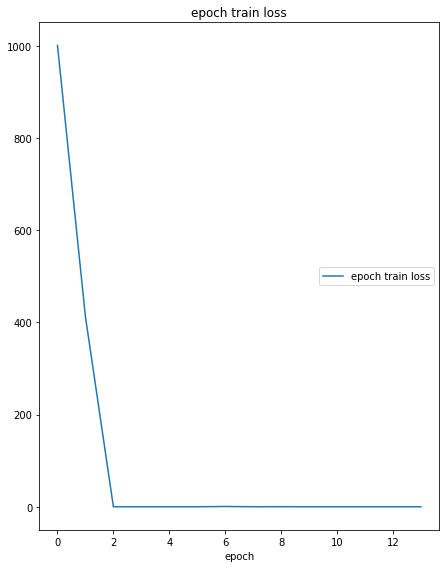

epoch train loss
	epoch train loss 	 (min:    0.000, max: 1001.070, cur:    0.000)
training worker process #0 finished
finished monitoring training


43.06141394376755

In [79]:
current_trainer, graph_metric_nn, model = init_embedding_net_and_trainer(model_factory_func, solver_params, problem_params, graph_metric_nn_checkpoint_path=None)

current_trainer.train(processes_device_ids=processes_device_ids, use_existing_data_loaders=False, train_samples_list=train_pairs, val_samples_list=test_pairs)

In [68]:
solver_params["max_epochs"] = 50
trainer, graph_metric_nn, model = init_embedding_net_and_trainer(model_factory_func, solver_params, problem_params, graph_metric_nn_checkpoint_path=None)

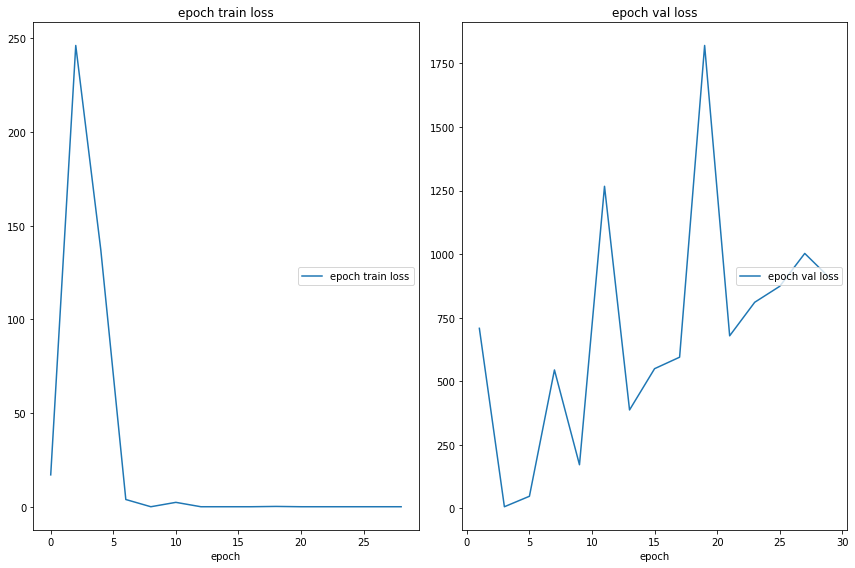

epoch train loss
	epoch train loss 	 (min:    0.000, max:  246.246, cur:    0.000)
epoch val loss
	epoch val loss   	 (min:    6.363, max: 1820.932, cur:  906.086)
training worker process #0 finished
finished monitoring training


In [69]:
model.eval()
val_loss = trainer.train(processes_device_ids=processes_device_ids, use_existing_data_loaders=False, train_samples_list=train_pairs, val_samples_list=test_pairs)

In [70]:
val_loss

6.362881522625685

In [76]:
val_loss

6.362881522625685

In [76]:
trainer, graph_metric_nn, model = init_embedding_net_and_trainer(model_factory_func, solver_params, problem_params, graph_metric_nn_checkpoint_path=".\\mp\\1707824192.5829558\\best_model_state_dict.pt")

In [77]:
# check greedy inference result, for speficic target graph's pairs
train_positive_distances, train_negative_distances, self_pair = get_pairs_distances_for_target_graph(trainer, graph_metric_nn, target_k_subgraph_label = target_graph_with_multiple_isomorphic_graphs_label, all_pairs=brute_force_train_samples_list, all_graphs=brute_force_k_subgraph_annotated_graphs)

In [78]:
train_positive_distances

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [79]:
sorted(train_negative_distances)

[6.958282947540283,
 6.958282947540283,
 6.958285808563232,
 6.958287239074707,
 6.958287239074707,
 6.958287239074707,
 15.711825370788574,
 15.711827278137207,
 15.711827278137207,
 15.711827278137207,
 15.711827278137207,
 15.711827278137207,
 22.350427627563477,
 22.350427627563477,
 22.350427627563477,
 22.350427627563477,
 22.350431442260742,
 22.350431442260742,
 22.350433349609375,
 22.350433349609375,
 22.350433349609375,
 22.350433349609375,
 22.350433349609375,
 22.35043716430664,
 31.87480354309082,
 31.87480354309082,
 31.87480354309082,
 31.87480354309082,
 31.87480354309082,
 31.87480354309082,
 35.878787994384766,
 35.878787994384766,
 35.878787994384766,
 35.878787994384766,
 35.878787994384766,
 35.878787994384766,
 35.878787994384766,
 35.878787994384766,
 35.878787994384766,
 35.878787994384766,
 35.878787994384766,
 35.878787994384766,
 35.878787994384766,
 35.878787994384766,
 35.878787994384766,
 35.878787994384766,
 35.87879180908203,
 35.87879180908203,
 35.878

In [80]:
len(train_positive_distances)

11

In [81]:
len(train_negative_distances)

409

In [91]:
def analyze_model_distances(trainer, graph_metric_nn, pairs, plot_range_max=20):
    train_positive_distances, train_negative_distances = get_examples_distances(trainer, graph_metric_nn, pairs)
    print(f"positive pairs distances= {len(train_positive_distances)}")
    print(f"negative pairs distances= {len(train_negative_distances)}")
    print(f"max positive pairs distance = {max(train_positive_distances)}")
    print(f"min negative pairs distance = {min(train_negative_distances)}")
    plot_histogram(train_positive_distances, "positive pair distances", min_range=0, max_range=plot_range_max)
    plot_histogram(train_negative_distances, "negative pair distances", min_range=0, max_range=plot_range_max)
    calc_margin_loss(torch.tensor(train_positive_distances+train_negative_distances), torch.cat((torch.ones(len(train_positive_distances)), torch.zeros(len(train_negative_distances)))), margin = solver_params['margin_loss_margin_value'])

positive pairs distances= 2916
negative pairs distances= 85074
max positive pairs distance = 7.46279149588247e-11
min negative pairs distance = 3.2498598098754883
0
20


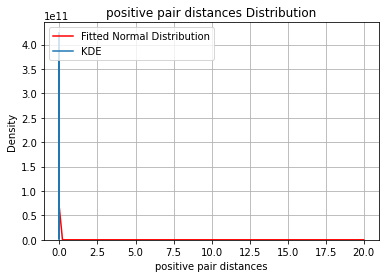

0
20


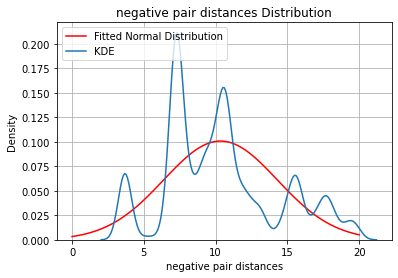

6.247120154512231e-09
187.58218383789062


In [92]:
# Analyze all dataset pairs
analyze_model_distances(trainer, graph_metric_nn, brute_force_train_samples_list)

positive pairs distances= 1422
negative pairs distances= 18279
max positive pairs distance = 1.964028939482887e-10
min negative pairs distance = 7.533687591552734
0
20


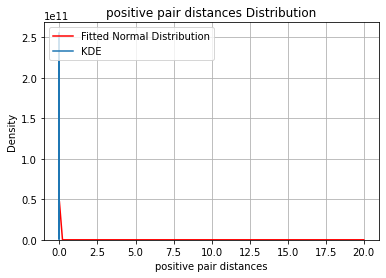

0
20


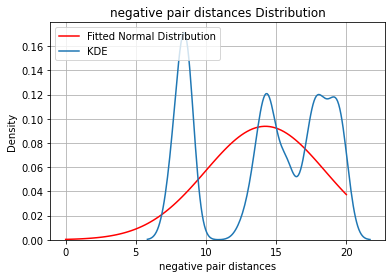

4.153124955053045e-09
0.0


In [93]:
# Analyze just training pairs
analyze_model_distances(trainer, graph_metric_nn, train_pairs)

positive pairs distances= 1494
negative pairs distances= 22816
max positive pairs distance = 2.7696955839928705e-11
min negative pairs distance = 2.322439670562744
0
20


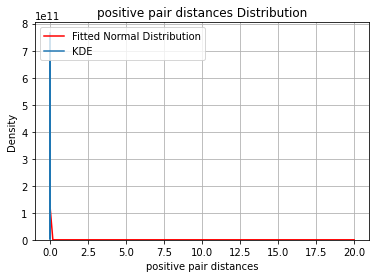

0
20


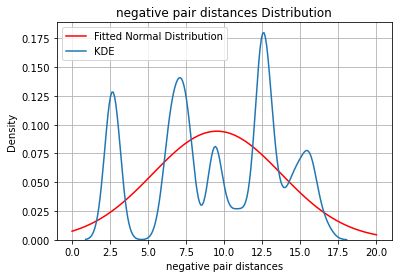

1.735354526744004e-09
795.1192016601562


In [94]:
# Analyze just validation pairs
analyze_model_distances(trainer, graph_metric_nn, test_pairs)